<a href="https://colab.research.google.com/github/RyutaNagai/repos_for_google-colab/blob/main/uj_prophet_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 外部ライブラリのインストール
!pip install mplfinance
!pip install pyti
!pip install mysqlclient
!pip install pandas-ta

# Finace indicatorを生成するライブラリ"TA-Lib"をinstall
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install
!pip install Ta-Lib

     |████████████████████████████████| 70 kB 2.6 MB/s 
     |████████████████████████████████| 87 kB 2.6 MB/s 
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99966 sha256=df9e5e944eb5fda6322c5105d52459d8cb9b4104ef42c1ae3d3ef23452dc91b1
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
Successfully built mysqlclient
     |████████████████████████████████| 115 kB 4.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=54d07f9076cf4fefc9bfb843310ef75ea06358a7554925ccb90542d55da3fd22
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta
--2022-03-23 04:01:13--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdown

In [2]:
db_host = '34.146.72.115'
pw = '39mmrvjz2DLH1NaO'

In [3]:
# ライブラリをインポート
import pandas as pd
import datetime as dt
import pandas.io.sql as psql
import MySQLdb
import mplfinance as mpf
import pyti
from pyti.bollinger_bands import upper_bollinger_band as bb_up
from pyti.bollinger_bands import middle_bollinger_band as bb_mid
from pyti.bollinger_bands import lower_bollinger_band as bb_low
import talib as ta

In [4]:
# MySQLへの接続関数
conn = MySQLdb.connect(
    host = db_host,
    user = 'root',
    password = pw,
    database = 'fxai',
    )
cur = conn.cursor()

In [5]:
# m1_candlesの値を読み込みData Frameに格納
sql_val = psql.read_sql("SELECT * from m1_candles;", conn)
df = pd.DataFrame(sql_val).sort_values("sys_time", ascending=False)

In [6]:
# 必要な列だけに絞り込み(USD/JPY)
df = df[[
         "sys_time",
          "USD_JPY_open",
          "USD_JPY_high",
          "USD_JPY_low",
          "USD_JPY_close",
          "USD_JPY_volume"
          ]]

In [7]:
# 重複する行（週末データ）を削除しつつ、直近の５００レコードに絞り込み
df_unique = df.drop_duplicates().head(240)

In [8]:
# 日時で昇順に並べ替え直し
df_acsend = pd.DataFrame(df_unique).sort_values("sys_time", ascending=True)

In [9]:
# time_stamp列をindexに指定
df_index = df_acsend.set_index("sys_time")

In [10]:
df_uj =df_index.rename(columns={
    "USD_JPY_open":"open",
    "USD_JPY_high":"high",
    "USD_JPY_low":"low",
    "USD_JPY_close":"close",
    "USD_JPY_volume":"volume"
    })

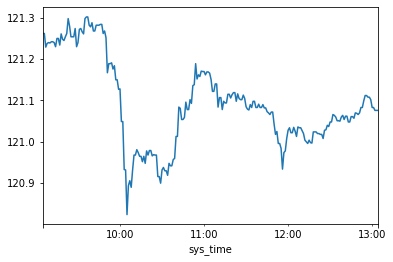

In [11]:
# 終値の推移をグラフで表示
df_uj['close'].plot()

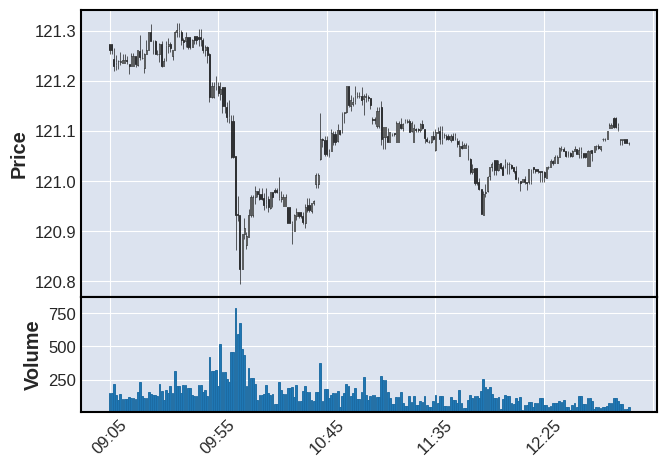

In [12]:
# ローソク足と出来高を表示
mpf.plot(df_uj, type='candle', volume=True)

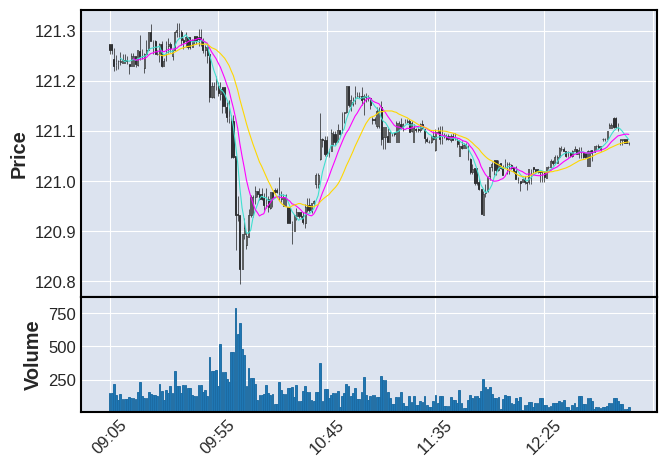

In [13]:
# ローソク足、移動平均、出来高を同時に表示
mpf.plot(ｄｆ_uj, type='candle', mav=(6, 12, 24), volume=True)

In [14]:
# ボリンジャーバンド値を取得
data = df_uj['close'].tolist() # 終値をリスト型に変換
period = 24
bb_up  = bb_up(data, period)  # バンド上限
bb_mid = bb_mid(data, period) # ミッドバンド
bb_low = bb_low(data, period) # バンド下限

In [15]:
# ボリンジャーバンド値をData Frameにセット
df_uj['bb_up']  = bb_up
df_uj['bb_mid'] = bb_mid
df_uj['bb_low'] = bb_low

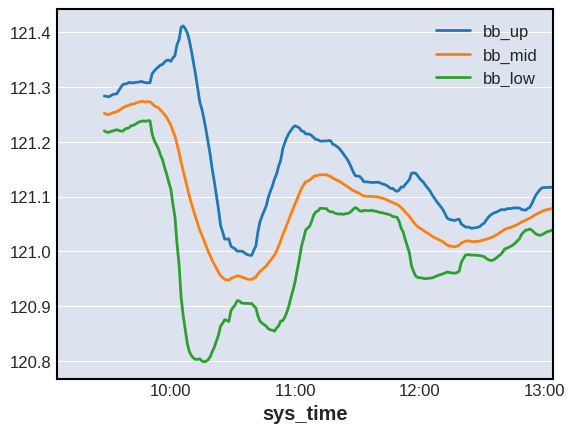

In [16]:
# ボリンジャーバンドを表示
df_uj[['bb_up', 'bb_mid', 'bb_low']].plot()

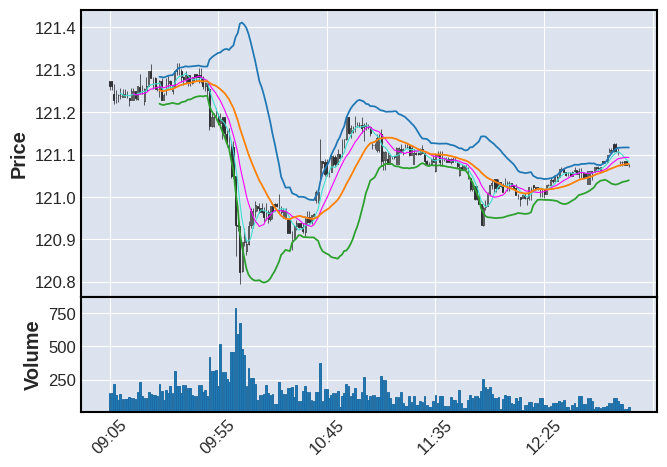

In [17]:
# ローソク足、移動平均、出来高、ボリンジャーバンドを同時に表示
apd = mpf.make_addplot(df_uj[['bb_up', 'bb_mid', 'bb_low']])
mpf.plot(df_uj, type='candle', mav=(6, 12, 24), addplot=apd, volume=True)

In [18]:
# 終値からMACDを計算
close = df_uj['close']
macd, macdsignal, _ = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df_uj['macd'] = macd
df_uj['macd_signal'] = macdsignal
df_uj.tail()

,open,high,low,close,volume,bb_up,bb_mid,bb_low,macd,macd_signal
sys_time,,,,,,,,,,
2022-03-23 13:00:00,121.082,121.084,121.072,121.083,65,121.116502,121.074667,121.032831,0.014509,0.013986
2022-03-23 13:01:00,121.082,121.084,121.072,121.083,65,121.116697,121.076042,121.035387,0.012798,0.013748
2022-03-23 13:02:00,121.084,121.084,121.076,121.076,27,121.116810,121.076708,121.036606,0.010754,0.013149
2022-03-23 13:03:00,121.084,121.084,121.076,121.076,27,121.116962,121.077208,121.037455,0.009029,0.012325
2022-03-23 13:04:00,121.076,121.078,121.071,121.076,46,121.116692,121.078125,121.039558,0.007575,0.011375


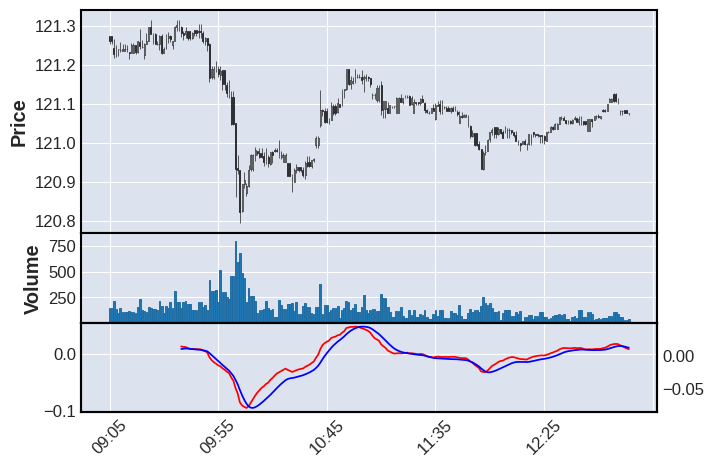

In [19]:
# MACDを表示
mdf = df_uj
apd  = [
    mpf.make_addplot(mdf['macd'], panel=2, color='red'), # パネルの2番地に赤で描画
    mpf.make_addplot(mdf['macd_signal'], panel=2, color='blue'), 
]
mpf.plot(mdf, type='candle', volume=True, addplot=apd)

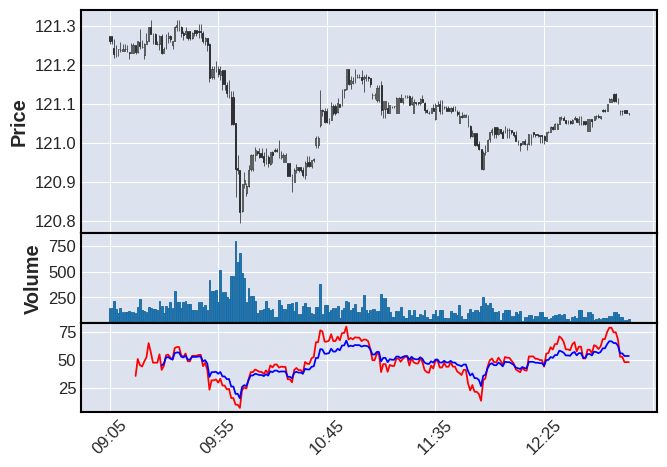

In [20]:
# RSIを表示
rsi12 = ta.RSI(close, timeperiod=12)
rsi24 = ta.RSI(close, timeperiod=24)
df_uj['rsi12'], df_uj['rsi24'] = rsi12, rsi24
mdf = df_uj.tail(500)
apd  = [
    mpf.make_addplot(mdf['rsi12'], panel=2, color='red'),
    mpf.make_addplot(mdf['rsi24'], panel=2, color='blue')
]
mpf.plot(mdf, type='candle', volume=True, addplot=apd)

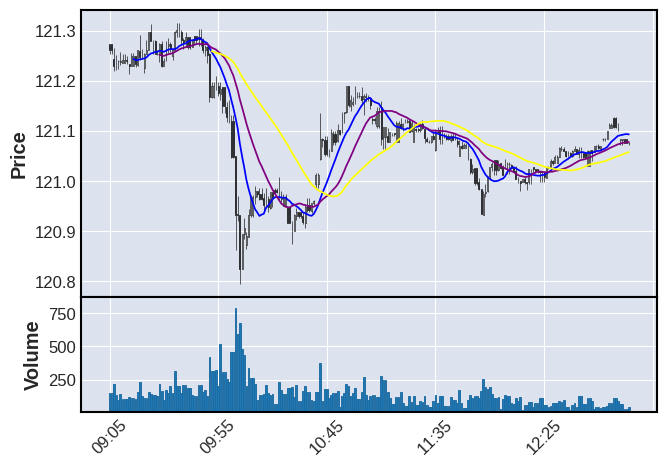

In [21]:
# 移動平均を表示
ma12, ma24, ma48  = ta.SMA(close, timeperiod=12), ta.SMA(close, timeperiod=24), ta.SMA(close, timeperiod=48)
df_uj['ma12'], df_uj['ma24'], df_uj['ma48'] = ma12, ma24, ma48
mdf = df_uj.tail(500)
apd  = [
    mpf.make_addplot(mdf['ma12'], panel=0, color='blue'),
    mpf.make_addplot(mdf['ma24'], panel=0, color='purple'),
    mpf.make_addplot(mdf['ma48'], panel=0, color='yellow'),
]
mpf.plot(mdf, type='candle', volume=True, addplot=apd)

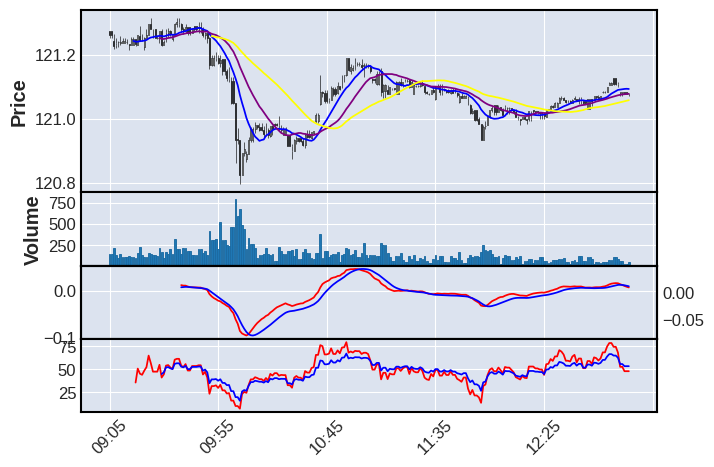

In [22]:
# 移動平均、MACD、RSIを同時に表示
mdf = df_uj.tail(500)
apd  = [
    mpf.make_addplot(mdf['ma12'], panel=0, color='blue'),
    mpf.make_addplot(mdf['ma24'], panel=0, color='purple'),
    mpf.make_addplot(mdf['ma48'], panel=0, color='yellow'),
    mpf.make_addplot(mdf['macd'], panel=2, color='red'),
    mpf.make_addplot(mdf['macd_signal'], panel=2, color='blue'),
    mpf.make_addplot(mdf['rsi12'], panel=3, color='red'),
    mpf.make_addplot(mdf['rsi24'], panel=3, color='blue')
]
mpf.plot(mdf, type='candle', volume=True, addplot=apd)

In [23]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640812 sha256=991b7247a175ed4df4e7777d001269427b006f4aef7041d09a7e7afe2e2b841b
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [27]:
df = df_uj.tail(240)
df["ds"] = df.index
df = df.rename(columns={'close': 'y'})
df = df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


sys_time
2022-03-23 09:05:00    121.262
2022-03-23 09:06:00    121.262
2022-03-23 09:07:00    121.229
2022-03-23 09:08:00    121.238
2022-03-23 09:09:00    121.240
                        ...   
2022-03-23 13:00:00    121.083
2022-03-23 13:01:00    121.083
2022-03-23 13:02:00    121.076
2022-03-23 13:03:00    121.076
2022-03-23 13:04:00    121.076
Name: y, Length: 240, dtype: float64

In [26]:
# Prophetで1時間先を予測
from prophet import Prophet
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
fig = m.plot(forecast)

ValueError: ignored